 # **AI Machine Learning & Analitics Final Project**
[poner todos los nombres]

**Chosen topic**
Image classification – Recognizing natural scenes

*Building a classification system that recognizes when pictures include different 
elements of a city or nature based on previously labelled images.*

### **Background information & analisis**
- talk about multiclass classification (it's what we have to do)
- talk about transfer learning and possible models we could fine tune and use for the project, apart from making it ourselves

### **Code**

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [34]:
# Function to load labelled data from the source folders 
def load_images(data_dir):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Get the folders/classes (labels)

    # Loop through all folders
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        print('Loading class %s' %class_name)
        
        if os.path.isdir(class_folder):
            # Loop through each image file within the class folder
            for img_name in os.listdir(class_folder)[0:1000]:
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load the image, resize it, and convert to a numpy array
                    img = Image.open(img_path)
                    img = img.resize((150,150)) # Resize in case there are images of different sizes and channels
                    img_array = np.array(img)

                    # Add the image to the list and its corresponding label (class index)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, classes

In [35]:
# Actually load the data from the folders
data_dir_train = '../data/seg_train'
data_dir_test = '../data/seg_test'

x_train, y_train, train_classes = load_images(data_dir_train)
x_test, y_test, test_classes = load_images(data_dir_test)

print(f"\nLoaded trian_images: {x_train.shape}")
print(f"Loaded train_labels: {y_train.shape}")
print(f"train_Classes: {train_classes}")

print(f"\nLoaded test_images: {x_test.shape}")
print(f"Loaded test_labels: {y_test.shape}")
print(f"test_Classes: {test_classes}")

Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street
Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street

Loaded trian_images: (6000, 150, 150, 3)
Loaded train_labels: (6000,)
train_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Loaded test_images: (3000, 150, 150, 3)
Loaded test_labels: (3000,)
test_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [36]:
# Process the image data and labels

# Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

# One hot encoding
y_train = to_categorical(y_train, 6) # Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
y_test = to_categorical(x_train, 6)

[1. 0. 0. 0. 0. 0.]


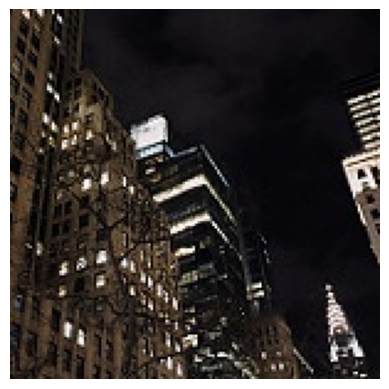

In [41]:
# Check if data is formatted correctly
print(y_train[0]) #Shows the one hot encoding and classification of the first image

plt.imshow(x_train[0])
plt.axis('off')
plt.show()